In [1]:
import torch
import torch.nn as nn
import torch.utils.data
import helpers

from PIL import Image, ImageFile
from timeit import default_timer as timer
from pathlib import Path
from torchvision.transforms import v2
from torchvision import datasets
from torch.utils.data import DataLoader
from model_vig import vig_ti_224_gelu
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from helpers import plot_loss_curves


device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

train_dir = Path("./data/eksperimen-3/train/")
test_dir = Path("./data/eksperimen-3/test/")

torch.cuda.empty_cache()

train_preprocess = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize((224, 224)),
        v2.RandomErasing(p=0.25),
        v2.RandAugment(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

test_preprpocess = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize((224, 224)),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

train_dataset = datasets.ImageFolder(str(train_dir), transform=train_preprocess)
test_dataset = datasets.ImageFolder(str(test_dir), transform=test_preprpocess)
class_names = train_dataset.classes

print(f"Total train image: {len(train_dataset)}")
print(f"Total test image: {len(test_dataset)}")
print(f"Classes/label: {class_names}")

NUM_WORKERS = 4
BATCH_SIZE = 128

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

cuda
Total train image: 1280
Total test image: 500
Classes/label: ['downdog', 'goddess', 'plank', 'tree', 'warrior2']


In [2]:
model = vig_ti_224_gelu(num_classes=1000).to(device)
model_path = "./pretrained/vig_ti_74.5.pth"
checkpoint = torch.load(model_path)
# if not model.distillation:
#     state_dict = {k: v for k, v in state_dict.items() if "dist_head" not in k}

model.load_state_dict(checkpoint, strict=False)

dpr [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
num_knn [9, 9, 10, 11, 12, 13, 13, 14, 15, 16, 17, 18]


<All keys matched successfully>

In [3]:
model.to(device)

DeepGCN(
  (stem): Stem(
    (convs): Sequential(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): GELU(approximate='none')
      (6): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): GELU(approximate='none')
      (9): Conv2d(96, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (10): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): GELU(approximate='none')
      (12): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): BatchNorm2d(192, eps=1e-05, momentum=0.

In [4]:
from torchinfo import summary

summary(
    model=model,
    input_size=(32, 3, 224, 224),  # make sure this is "input_size", not "input_shape"
    # col_names=["input_size"], # uncomment for smaller output
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

Layer (type (var_name))                                                Input Shape          Output Shape         Param #              Trainable
DeepGCN (DeepGCN)                                                      [32, 3, 224, 224]    [32, 1000]           37,632               True
├─Stem (stem)                                                          [32, 3, 224, 224]    [32, 192, 14, 14]    --                   True
│    └─Sequential (convs)                                              [32, 3, 224, 224]    [32, 192, 14, 14]    --                   True
│    │    └─Conv2d (0)                                                 [32, 3, 224, 224]    [32, 24, 112, 112]   672                  True
│    │    └─BatchNorm2d (1)                                            [32, 24, 112, 112]   [32, 24, 112, 112]   48                   True
│    │    └─GELU (2)                                                   [32, 24, 112, 112]   [32, 24, 112, 112]   --                   --
│    │    └─Conv2d (3)  

In [5]:
for param in model.stem.parameters():
    param.requires_grad = False

for param in model.backbone.parameters():
    param.requires_grad = False

In [6]:
model.prediction = nn.Sequential(
    nn.Conv2d(192, 1024, 1, bias=True),
    nn.BatchNorm2d(1024),
    nn.GELU(),
    nn.Dropout(0.0),
    nn.Conv2d(1024, len(class_names), 1, bias=True),
)


model.to(device)

DeepGCN(
  (stem): Stem(
    (convs): Sequential(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): GELU(approximate='none')
      (6): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): GELU(approximate='none')
      (9): Conv2d(96, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (10): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): GELU(approximate='none')
      (12): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): BatchNorm2d(192, eps=1e-05, momentum=0.

In [7]:
LEARNING_RATE = 0.002
NUM_EPOCHS = 5

loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

num_training_steps = NUM_EPOCHS * len(train_dataloader)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer=optimizer,
    T_max=num_training_steps,
)

In [8]:
import torch.utils.data


def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    progress_bar: tqdm | None = None,
) -> Tuple[float, float]:
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)
        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()
        lr_scheduler.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

        if progress_bar:
            progress_bar.update(1)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc


In [9]:
def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device: torch.device,
    progress_bar: tqdm | None = None,
) -> Tuple[float, float]:
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)

            if progress_bar:
                progress_bar.update(1)

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


In [10]:
def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int,
    device: torch.device,
    use_progress_bar: bool = False,
) -> Dict[str, List]:
    # Create empty results dictionary
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    if use_progress_bar:
        progress_bar = tqdm(
            total=len(train_dataloader) + len(test_dataloader), desc="Processing Batch"
        )

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs), desc="Processing Epoch"):
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device,
            progress_bar=progress_bar if use_progress_bar else None,
        )
        test_loss, test_acc = test_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device,
            progress_bar=progress_bar if use_progress_bar else None,
        )

        print(
            f"Epoch: {epoch+1} | Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f} | Train acc: {train_acc*100:.2f}% | Test acc: {test_acc*100:.2f}% | LR: {lr_scheduler.get_last_lr()}"
        )
        progress_bar.reset()
        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results


In [11]:
print(device)

torch.manual_seed(42)
torch.cuda.manual_seed(42)
Image.LOAD_TRUNCATED_IMAGES = True
ImageFile.LOAD_TRUNCATED_IMAGES = True


# Start the timer
start_time = timer()

# Setup training and save the results
results = train(
    model=model.to(device),
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=NUM_EPOCHS,
    device=torch.device(device),
    use_progress_bar=True,
)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")


cuda


Processing Batch:   0%|          | 0/14 [00:00<?, ?it/s]

Processing Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 1.29250 | Test loss: 2.36890 | Train acc: 50.23% | Test acc: 20.14% | LR: [0.0018090169943749473]
Epoch: 2 | Train loss: 0.98831 | Test loss: 0.91027 | Train acc: 70.94% | Test acc: 75.17% | LR: [0.001309016994374947]
Epoch: 3 | Train loss: 0.91164 | Test loss: 0.92423 | Train acc: 75.23% | Test acc: 74.24% | LR: [0.0006909830056250527]
Epoch: 4 | Train loss: 0.85994 | Test loss: 0.79858 | Train acc: 77.34% | Test acc: 81.35% | LR: [0.00019098300562505252]
Epoch: 5 | Train loss: 0.87674 | Test loss: 0.74424 | Train acc: 77.11% | Test acc: 84.34% | LR: [0.0]
[INFO] Total training time: 1550.860 seconds


In [12]:
import pickle
import json

with open("./results/test2.pkl", "wb") as f:
    pickle.dump(results, f)


with open("./results/test2.pkl", "rb") as f:
    loaded_dict = pickle.load(f)

print(json.dumps(results, indent=4))


{
    "train_loss": [
        1.292495882511139,
        0.9883093357086181,
        0.9116390645503998,
        0.8599384307861329,
        0.8767405807971954
    ],
    "train_acc": [
        0.50234375,
        0.709375,
        0.75234375,
        0.7734375,
        0.77109375
    ],
    "test_loss": [
        2.368902564048767,
        0.910271406173706,
        0.9242280125617981,
        0.7985835820436478,
        0.7442444115877151
    ],
    "test_acc": [
        0.2013739224137931,
        0.7516837284482758,
        0.7423895474137931,
        0.8135102370689655,
        0.8434132543103449
    ]
}


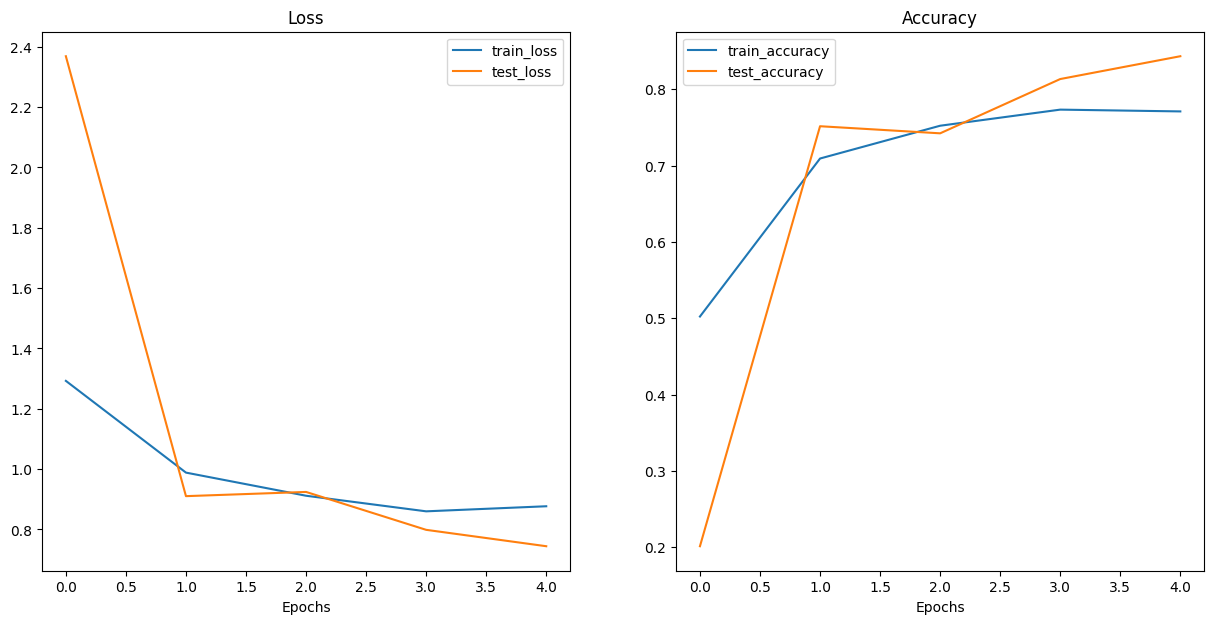

In [13]:
# Plot the loss curves of our model
plot_loss_curves(results)


In [14]:
save_dir = Path("./models/test2.pth")

torch.save(
    {
        "epoch": NUM_EPOCHS,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
    },
    save_dir,
)


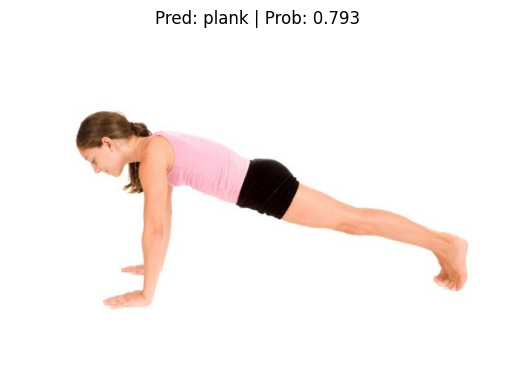

In [15]:
# Setup path to data folder
custom_image_path = Path("./data/eksperimen-3/test/plank/00000074.jpg")

# Predict on custom image
helpers.pred_and_plot_image(
    model=model, image_path=str(custom_image_path), class_names=class_names
)
